# Author: Midrar Adham
## Homework 2: Pinhole Camera geometry

In [16]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

### Inputs:

- I've taken two images of a checkerboard.
- The focal length is 1 ft and 22 inches.
- The horizontal axis difference between the two images is 11 inches

In [17]:
def read_images (img):
    img = cv.imread(f'../../sample_data/{img}.JPG')
    return img

def para_plots(img1, img2):
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,10))
    fig.tight_layout()
    ax[0].set_title('Original Image')
    ax[0].imshow(img1)
    ax[1].set_title('Modified Image')
    ax[1].imshow(img2)

**Choose a calibration target with points at known locations. This may be a checker board or anything else you wish to use. Include a picture of your calibration target**
----

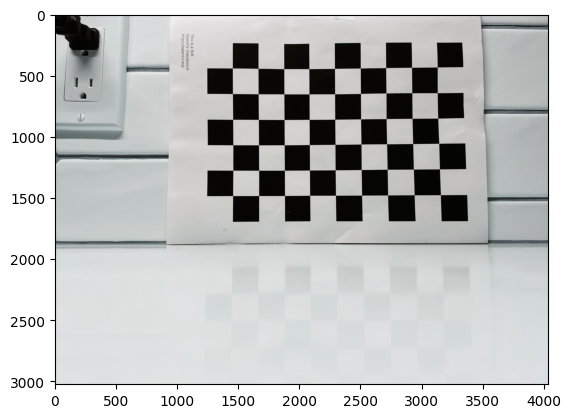

In [18]:
images = 'pattern_1'
img = read_images(img = images)
plt.imshow(img)

**Explain your rationale for using this calibration target.**
----

- Clear pattern.
- Specified dimensions (6x9)
- Therefore, it is easy to process.

**Describe the known geometry of the calibration target. What are the positions of the known points on the target?**
----

- The corners of the checkerboard are known.
- The beginning and ending coordinates of each square are known.
    - The checkerboard has 9 rows and 6 columns.

**Use the calibration target to estimate the camera intrinsic parameters (and preferably the distortion parameters). Write the results of the calibration for the intrinsic camera parameters.**
----

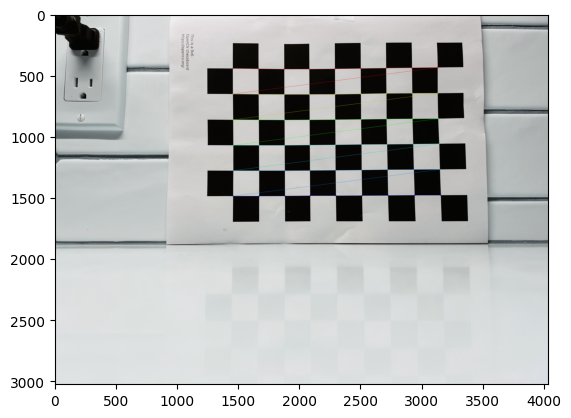

reprojection_error = 
1.4863803409696195

camera_matrix = 
[[9.86586854e+03 0.00000000e+00 1.84853288e+03]
 [0.00000000e+00 1.00604739e+04 1.43170162e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


distortion_coefficients = 
[[ 3.78314431e+00 -1.70539377e+02 -7.49449683e-03 -3.54180683e-02
   3.13588445e+03]]



In [19]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

'''
The objp variable is very confusing. Here is a brief explaination. 

1- To calculate the projection matrix, we need 2D coordinates and 3D coordinates.
2- The 2D coordinates can be easily found using openCV method (findchessboardCorners)
3- The 3D coordinates, however, needs some pre-defined variables.
    3A- Create a matrix with the size of the your checkerboard image.
    3B- This matrix may contain just zeroes. It does not matter. These points will be updated later.
    3C- The point is this matrix contains 54 rows and three columns. Each column is x,y, and z of the
    world coordinates frame.
    4D- The next line generates a grid of 2D points. This grid is then mapped to the previously created array
    without the z-axis. Since this is a flat image, the z-axis will remain zero.
'''
squares_size = 3 # in centimeters
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) * squares_size

world_3d_points = []
img_plane_2d_points = []


image = read_images(img=images)
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

corners_found, corners = cv.findChessboardCorners(image = gray,
                                                  patternSize=(9,6),
                                                  flags=None)

if corners_found == True:
    world_3d_points.append(objp)
    corners2 = cv.cornerSubPix(image=gray,
                                corners=corners,
                                winSize=(11,11),
                                zeroZone=(-1,-1), # A neglected zone. The -1,-1 is like None.
                                criteria=criteria
                                ) # more accurate corners (in subpixels)
    
    img_plane_2d_points.append(corners)
    cv.drawChessboardCorners(image=image,
                             patternSize=(9,6),
                             corners=corners2,
                             patternWasFound=corners_found)
    plt.imshow(image)
    plt.show()

image_size = gray.shape[::-1]
reprojection_error, camera_matrix, distortion_coefficients, rotation_vectors, translation_vectors = cv.calibrateCamera(world_3d_points,
                                                                                                                    img_plane_2d_points,
                                                                                                                       image_size,
                                                                                                                       None,
                                                                                                                       None,
                                                                                                                       )

print(f'reprojection_error = \n{reprojection_error}\n')
print(f'camera_matrix = \n{camera_matrix}\n')
print(f'\ndistortion_coefficients = \n{distortion_coefficients}\n')


**Describe how you performed the intrinsic estimation, and your rationale for doing so. If using a function in a software package, explain in mathematical terms what the package does.**
----

I used the ```cv.caliberatecamera``` method to calculate the intrinsic parameters of the camera. **Note** that the aforementioned method does **not** return the intrinsic matrix itselt. Rather, it returns the attributes that form the intrinsic matrix. The ```cv.caliberatecamera``` method uses the following steps to perform the calculation of the intrinsic matrix:

- A set of 3D point from the camera model. This set contains the points from which the x,y, and z coordinates are specified (size of the chessboard, the coordinates of each edge of the squares within the checkersboard).

- The returned ```camera_matrix``` contains only the **intrinsic** parameters of the camera.
- The **extrinsic** parameters are returned from the ```rotation_vectors``` $\&$ ```translation_vectors``` variables.

#### Interpertations of the returned values of the ```caliberateCamera()``` method:

The ```camera_matrix``` contains the following values:

$$
\Lambda =
\begin{equation*}
\begin{bmatrix}
f_{x} & 0 & c_{x}\\
0 & f_{y} & c_{y}\\
0 & 0 & 1
\end{bmatrix}
\end{equation*}
$$

Where:

- The $f_{x}$ and $f_{y}$ are the focal length coordinates. 
- The $c_{x}$ and $c_{y}$ are the optical center coordinates.

Both of the $f$ and $c$ are the **intrinsic parameters** ($\Lambda$) of the camera. This matrix (1) can be mapped to the output produced by the ```caliberateCamera()``` method, such that:

$$
\Lambda =
\begin{bmatrix}
9.8659e+3 & 0.0 & 1.8485e+3\\
0.0 & 1.0060e+3 & 1.4317e+3\\
0.0 & 0.0 & 1

\end{bmatrix}
$$

**Perform extrinsic calibration. Explain how you did this, and your rationale for doing so.**
----

In [20]:
print(f'rotation_vectors = \n{rotation_vectors}\n')
print(f'translation_vectors = \n{translation_vectors}\n')

rotation_vectors = 
(array([[0.00706506],
       [0.3623655 ],
       [3.11746623]]),)

translation_vectors = 
(array([[ 18.43579719],
       [  0.70029772],
       [141.61488532]]),)



The ```caliberateCamera``` method retruns the rotation and translation vectors. These two vectors form the **extrinsic parameters** of the camera. The extrinsic matrix contains the rotation ($\Omega$) and translation ($\tau$) vectors. The extrinsic matrix contains the following:
$$
\Omega = 
\begin{equation*}
\begin{bmatrix}
r_{11} & r_{12} & r_{13}\\
r_{21} & r_{22} & r_{23}\\
r_{31} & r_{32} & r_{33}
\end{bmatrix}
\end{equation*}
$$

The translation matrix: 

$$
\tau = 
\begin{equation*}
\begin{bmatrix}
t_{x}\\
t_{y}\\
t_{z}
\end{bmatrix}
\end{equation*}
$$

Both the $\Omega$ \& $\tau$ form the extrinsic matrix:

$$
\begin{equation*}
\begin{bmatrix}

r_{11} & r_{12} & r_{13} & t_{x}\\
r_{21} & r_{22} & r_{23} & t_{y}\\
r_{31} & r_{32} & r_{33} & t_{z}\\
0 & 0 & 0 & 1

\end{bmatrix}
\end{equation*}
$$


Note that the  ```rotation_vectors``` and the ```translation_vectors``` are three rows and one column. So, we can't directly write those in extrinsic matrix format. Therefore, we use [Rodrigues formula](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga61585db663d9da06b68e70cfbf6a1eac) to convert the three rows and one column vectors to a 3x3 matrix. Also note that the returned vectors from the ```caliberatecamera``` are **in fact** tuple, not numpy array.

In [21]:
# Convert the retruned tuple from the caliberatecamera method to vectors and get their 3x3 matrix.
rotation_matrix, _ = cv.Rodrigues(src=rotation_vectors[0])

Now we have the rotation matrix ready as follows:

$$
\Omega = 
\begin{equation*}
\begin{bmatrix}
-0.9999 & -0.0026 & 0.0048\\
0.0036 & -0.9733 & 0.2293\\
0.0041 & 0.2294 & 0.9733
\end{bmatrix}
\end{equation*}
$$

Since the translation vectors are in the right format (one column and three rows), we don't need to convert them. We will only extract the vector from the tuple, which gives us:

$$
\tau = 
\begin{equation*}
\begin{bmatrix}
18.4358\\
0.7003\\
141.6149
\end{bmatrix}
\end{equation*}
$$

Now we can construct the extrinsic matrix:

$$
\begin{equation*}
\begin{bmatrix}
-0.9999 & -0.0026 & 0.0048 & 18.4358\\
0.0036 & -0.9733 & 0.2293 & 0.7003\\
0.0041 & 0.2294 & 0.9733 & 141.6149\\
0 & 0 & 0 & 1

\end{bmatrix}
\end{equation*}
$$

**What is the reference system used for your world reference frame? Describe where the origin is, and the axes that establish the 3D Euclidean coordinate system.**
----

**3D world point estimation. Capture the location of the point for the camera at two known locations. Repeat this for several points. Include images from the camera side-by-side, with the coordinates of the point of interest indicated.**
----

**Compare the accuracy of the estimated point locations from the pixel coordinates of the two camera locations to the actual 3D locations of the points. How accurate were your estimates?**
----

**What did you learn from this assignment?**
----

**What questions, if any, do you have for me after completing this assignment?**
----